## 데이터 불러오기

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
col = px.colors.qualitative.Pastel

from pandas import DataFrame

from matplotlib import pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
np.random.seed(seed=42)

import plotly.io as pio
pio.renderers.default = "notebook_connected"
from datetime import timedelta
from plotly.subplots import make_subplots

random.seed(42)

In [2]:
sample_submission = pd.read_csv('sample_submission.csv')
site_info = pd.read_csv('site_info.csv')
energy = pd.read_csv('energy.csv')

dangjin_fcst_data=pd.read_csv('dangjin_fcst_data.csv')
dangjin_obs_data = pd.read_csv('dangjin_obs_data.csv')
ulsan_fcst_data = pd.read_csv('ulsan_fcst_data.csv')
ulsan_obs_data = pd.read_csv('ulsan_obs_data.csv')

In [3]:
# pd.set_option('display.max_rows',10000)

## EDA

### site_info

Capacity : 발전소 발전용량(MW)

InstallationAngle : 설치각(º)

IncidentAngle : 입사각(º)

In [4]:
site_info

,Id,Capacity,Address,InstallationAngle,IncidentAngle,Latitude,Longitude
0,당진수상태양광,1.00000,충남 당진시 석문면 교로길 30,30.00000,30.00000,37.05075,126.51030
1,당진자재창고태양광,0.70000,충남 당진시 석문면 교로길 30,30.00000,30.00000,37.05075,126.51030
2,당진태양광,1.00000,충남 당진시 석문면 교로길 30,30.00000,30.00000,37.05075,126.51030
3,울산태양광,0.50000,울산광역시 남구 용잠로 623,20.00000,20.00000,35.47765,129.38078


### energy

time : 1시간 단위 계량된 시간

dangjin_floating : 당진수상태양광 발전량(KW)

dangjin_warehouse : 당진자재창고태양광 발전량(KW)

dangjin : 당진태양광 발전량(KW)

ulsan : 울산태양광 발전량(KW)

In [5]:
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.00000,0.00000,0,0
1,2018-03-01 2:00:00,0.00000,0.00000,0,0
2,2018-03-01 3:00:00,0.00000,0.00000,0,0
3,2018-03-01 4:00:00,0.00000,0.00000,0,0
4,2018-03-01 5:00:00,0.00000,0.00000,0,0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.00000,0.00000,0,0
25628,2021-01-31 21:00:00,0.00000,0.00000,0,0
25629,2021-01-31 22:00:00,0.00000,0.00000,0,0
25630,2021-01-31 23:00:00,0.00000,0.00000,0,0


In [42]:
print(sum(energy['dangjin_floating'].isna())) # 24
print(sum(energy['dangjin_warehouse'].isna())) #48
print(sum(energy['dangjin'].isna())) #0
print(sum(energy['ulsan'].isna())) # 0

24
48
0
0


In [85]:
# datatime으로 변환해주기.
energy['date'] = energy['time'].apply(lambda x: x.split()[0])
energy['time'] = energy['time'].apply(lambda x: x.split()[1])
energy['time'] = energy['time'].str.rjust(8,'0') # 한 자릿수 시간 앞에 0 추가 

energy.loc[energy['time']=='24:00:00','time'] = '00:00:00' # 24시를 00시로 바꿔주기 (datatime으로 변환하기 위해)
energy['time'] = energy['date'] + ' ' + energy['time']
energy['time'] = pd.to_datetime(energy['time'])
energy.loc[energy['time'].dt.hour==0,'time'] += timedelta(days=1)

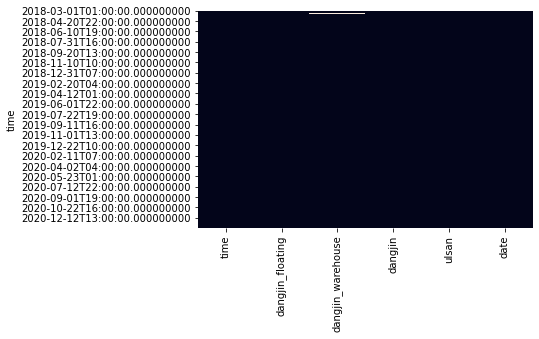

In [49]:
energy1=energy
energy1.index=energy1['time']
energy1.drop(['time'],axis=1)
sns.heatmap(energy1.isnull(),cbar=False)

In [61]:
energy_18_04=energy
energy_18_04['time']=energy_18_04['time'].astype(str)
energy_18_04=energy_18_04[energy_18_04['time'].str.contains('2018-04')]

In [62]:
energy_18.isna().sum()

time                  0
dangjin_floating      0
dangjin_warehouse    48
dangjin               0
ulsan                 0
date                  0
year                  0
dtype: int64

### 간단하게 보간 (2018년만)

In [12]:
energy_year=energy
energy_year['year'] = energy_year['time'].dt.year
energy_year['year']=energy_year['year'].astype(str)
energy_18=energy_year[energy_year['year'].str.contains('2018')]

In [14]:
energy_18_linear=energy_18.interpolate() # 선형 보간

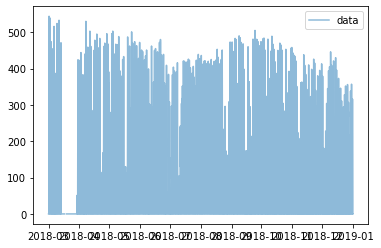

In [33]:
plt.plot(energy_18['time'], energy_18['dangjin_warehouse'],'-',alpha=0.5) 
plt.legend(['data','linear'], loc='best') 
plt.show()

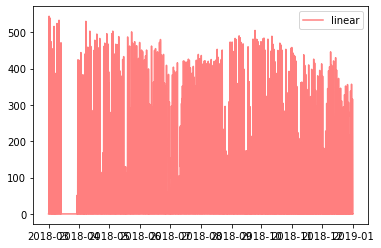

In [54]:
plt.plot(energy_18_linear['time'],energy_18_linear['dangjin_warehouse'],'-',alpha=0.5,color='red') 
plt.legend(['linear'], loc='best') 
plt.show()

### 년도별 태양열 발전량 (월별 평균)

In [8]:
energy['year'] = energy['time'].dt.year

In [9]:
energy['month'] = energy['time'].dt.month

In [10]:
energy_year=energy

In [11]:
energy['year']=energy['year'].astype(str)
energy_18=energy_year[energy_year['year'].str.contains('2018')]
energy_19=energy_year[energy_year['year'].str.contains('2019')]
energy_20=energy_year[energy_year['year'].str.contains('2020')]
energy_21=energy_year[energy_year['year'].str.contains('2021')]

In [12]:
energy['month'] = energy['time'].dt.month
mean_month_18 = energy_18.groupby('month').mean()
mean_month_19 = energy_19.groupby('month').mean()
mean_month_20 = energy_20.groupby('month').mean()
mean_month_21 = energy_21.groupby('month').mean()

In [13]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=mean_month_18.index,y=mean_month_18['dangjin_floating'],
             mode='lines+markers', name='18_df'))
fig.add_trace(go.Scatter(x=mean_month_19.index,y=mean_month_19['dangjin_floating'],
             mode='lines+markers', name='19_df'))
fig.add_trace(go.Scatter(x=mean_month_20.index,y=mean_month_20['dangjin_floating'],
             mode='lines+markers', name='20_df'))
fig.add_trace(go.Scatter(x=mean_month_21.index,y=mean_month_21['dangjin_floating'],
             mode='lines+markers', name='21_df'))

fig.update_layout(title='YEAR_dangjin_floating')

### 월별 태양열 발전량 (모든 년도 평균)

: 3~6월이 높은 것으로 보임.

In [14]:
energy['month'] = energy['time'].dt.month
mean_month = energy.groupby('month').mean()

In [15]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=mean_month.index,y=mean_month['dangjin_floating'],
             mode='lines+markers', name='df'))
fig.add_trace(go.Scatter(x=mean_month.index,y=mean_month['dangjin_warehouse'],
             mode='lines+markers', name='dw'))
fig.add_trace(go.Scatter(x=mean_month.index,y=mean_month['dangjin'],
             mode='lines+markers', name='dj'))
fig.add_trace(go.Scatter(x=mean_month.index,y=mean_month['ulsan'],
             mode='lines+markers', name='ul'))

fig.update_layout(title='MONTH_energy')

### 시간별 발전량 (모든 년도 평균)

: 11시~12시 최대

In [16]:
energy['hour'] = energy['time'].dt.hour
mean_hour = energy.groupby('hour').mean()

In [17]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=mean_hour.index,y=mean_hour['dangjin_floating'],
             mode='lines+markers', name='df'))
fig.add_trace(go.Scatter(x=mean_hour.index,y=mean_hour['dangjin_warehouse'],
             mode='lines+markers', name='dw'))
fig.add_trace(go.Scatter(x=mean_hour.index,y=mean_hour['dangjin'],
             mode='lines+markers', name='dj'))
fig.add_trace(go.Scatter(x=mean_hour.index,y=mean_hour['ulsan'],
             mode='lines+markers', name='ul'))

fig.update_layout(title='HOUR_energy')

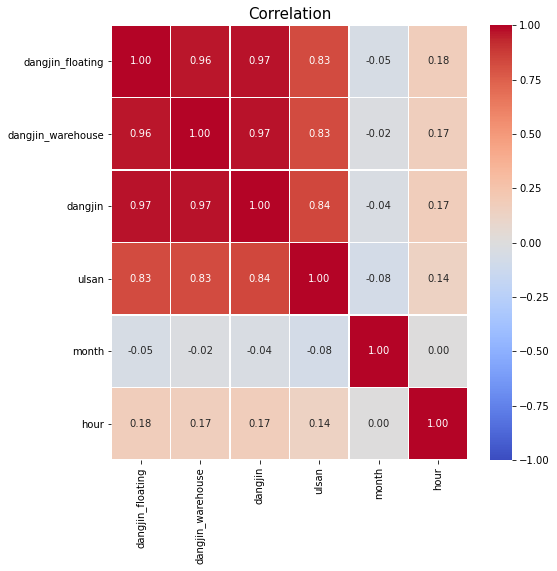

In [18]:
import seaborn as sns
plt.figure(figsize=(8,8))
plt.title("Correlation", fontsize=15)
sns.heatmap(data = energy.corr(),
            annot=True,
            fmt = '.2f', linewidths=.5, cmap='coolwarm',
           vmin = -1, vmax = 1, center = 0)
plt.show()

### dangjin_fcst_data

Cloud : 하늘상태(1-맑음, 2-구름보통, 3-구름많음, 4-흐림)

: NA 값이 없음.

In [3]:
dangjin_fcst_data_21=dangjin_fcst_data[dangjin_fcst_data['Forecast time'].str.contains('2021')]

In [3]:
dangjin_fcst_data['Forecast_time'] = pd.to_datetime(dangjin_fcst_data['Forecast time'])

In [4]:
dangjin_fcst=pd.read_csv('dangjin_fcst_data.csv')

In [5]:
def fcst_time_change(fcst, hour):
    fcst = [i for i in fcst]
    fcst_join = ''.join(fcst)
    temp_hour = int(fcst_join[11:13]) + hour
    temp_day = temp_hour // 24
    temp_hour = temp_hour % 24
    temp_day = int(fcst_join[8:10]) + temp_day
    
    if (int(fcst_join[5:7]) in [1, 3, 5, 7, 8, 10, 12]):
        if (temp_day > 31) :
            temp_month = temp_day // 32
            temp_day = temp_day % 32
        else:
            temp_month = 0
        
    if (int(fcst_join[5:7]) in [4, 6, 9, 11]):
        if (temp_day > 30):
            temp_month = temp_day // 31
            temp_day = temp_day % 31
        else:
            temp_month = 0
    
    if (int(fcst_join[5:7])==2):
        if (int(fcst_join[0:4]) % 4 != 0):
            if (temp_day > 28):
                temp_month = temp_day // 29
                temp_day = temp_day % 29
            else:
                temp_month = 0
        else :
            if (temp_day > 29):
                temp_month = temp_day // 30
                temp_day = temp_day % 30
            else:
                temp_month = 0
    
    if (temp_month > 0):
        temp_day = temp_day + 1
        
    temp_month = int(fcst_join[5:7]) + temp_month
    temp_year = int(fcst_join[0:4]) + temp_month // 13
    temp_month = temp_month % 13
    
    
        
    if temp_month == 0 : 
        temp_month = 1
        
    if (temp_hour < 10):
        fcst[11:13] = '0' + str(int(temp_hour))
    else:
        fcst[11:13] = str(int(temp_hour))
        
    if (temp_day < 10):
        fcst[8:10] = '0' + str(int(temp_day))
    else:
        fcst[8:10] = str(int(temp_day))
    
    if (temp_month < 10):
        fcst[5:7] = '0' + str(int(temp_month))
    else:
        fcst[5:7] = str(int(temp_month))
        
    fcst[0:4] = str(int(temp_year))
    
    return ''.join(fcst)

In [6]:
dangjin_fcst['target time'] = dangjin_fcst.apply(lambda x : fcst_time_change(x['Forecast time'], x['forecast']),axis = 1)

In [7]:
dangjin_fcst[dangjin_fcst['Forecast time']=='2018-03-01 17:00:00']

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,target time
39,2018-03-01 17:00:00,4.00000,-2.00000,60.00000,7.50000,326.00000,1.00000,2018-03-01 21:00:00
40,2018-03-01 17:00:00,7.00000,-2.00000,50.00000,5.80000,336.00000,1.00000,2018-03-02 00:00:00
41,2018-03-01 17:00:00,10.00000,-3.00000,55.00000,5.00000,339.00000,1.00000,2018-03-02 03:00:00
42,2018-03-01 17:00:00,13.00000,-4.00000,60.00000,4.10000,353.00000,1.00000,2018-03-02 06:00:00
43,2018-03-01 17:00:00,16.00000,-2.00000,55.00000,1.10000,360.00000,1.00000,2018-03-02 09:00:00
44,2018-03-01 17:00:00,19.00000,2.00000,45.00000,1.00000,259.00000,1.00000,2018-03-02 12:00:00
45,2018-03-01 17:00:00,22.00000,3.00000,55.00000,2.60000,274.00000,1.00000,2018-03-02 15:00:00
46,2018-03-01 17:00:00,25.00000,1.00000,60.00000,1.40000,278.00000,1.00000,2018-03-02 18:00:00
47,2018-03-01 17:00:00,28.00000,-1.00000,75.00000,2.40000,81.00000,1.00000,2018-03-02 21:00:00
48,2018-03-01 17:00:00,31.00000,-2.00000,75.00000,2.30000,95.00000,2.00000,2018-03-03 00:00:00


In [8]:
dangjin_fcst

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,target time
0,2018-03-01 11:00:00,4.00000,0.00000,60.00000,7.30000,309.00000,2.00000,2018-03-01 15:00:00
1,2018-03-01 11:00:00,7.00000,-2.00000,60.00000,7.10000,314.00000,1.00000,2018-03-01 18:00:00
2,2018-03-01 11:00:00,10.00000,-2.00000,60.00000,6.70000,323.00000,1.00000,2018-03-01 21:00:00
3,2018-03-01 11:00:00,13.00000,-2.00000,55.00000,6.70000,336.00000,1.00000,2018-03-02 00:00:00
4,2018-03-01 11:00:00,16.00000,-4.00000,55.00000,5.50000,339.00000,1.00000,2018-03-02 03:00:00
...,...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.00000,7.00000,40.00000,3.20000,187.00000,1.00000,2021-03-03 12:00:00
162204,2021-03-01 08:00:00,55.00000,8.00000,40.00000,4.50000,217.00000,1.00000,2021-03-03 15:00:00
162205,2021-03-01 08:00:00,58.00000,5.00000,55.00000,2.20000,210.00000,1.00000,2021-03-03 18:00:00
162206,2021-03-01 08:00:00,61.00000,1.00000,80.00000,1.90000,164.00000,1.00000,2021-03-03 21:00:00


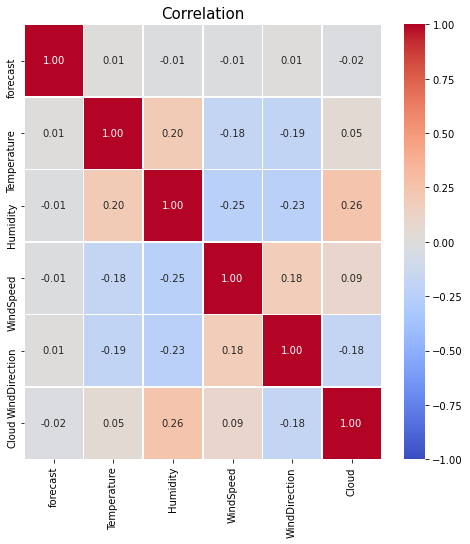

In [21]:
import seaborn as sns
plt.figure(figsize=(8,8))
plt.title("Correlation", fontsize=15)
sns.heatmap(data = dangjin_fcst_data.corr(),
            annot=True,
            fmt = '.2f', linewidths=.5, cmap='coolwarm',
           vmin = -1, vmax = 1, center = 0)
plt.show()

### ulsan_fcst_data

Cloud : 하늘상태(1-맑음, 2-구름보통, 3-구름많음, 4-흐림)

: NA 값이 없음.

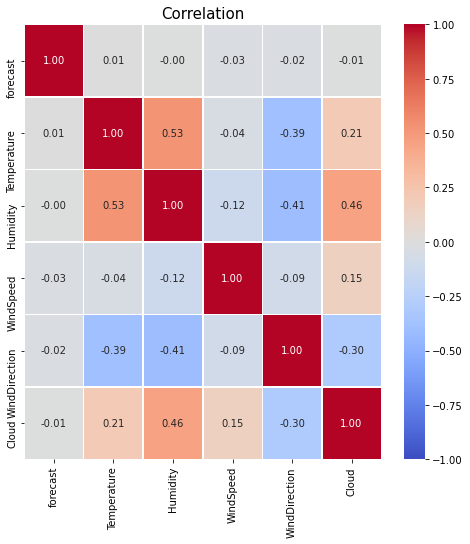

In [22]:
import seaborn as sns
plt.figure(figsize=(8,8))
plt.title("Correlation", fontsize=15)
sns.heatmap(data = ulsan_fcst_data.corr(),
            annot=True,
            fmt = '.2f', linewidths=.5, cmap='coolwarm',
           vmin = -1, vmax = 1, center = 0)
plt.show()

### dangjin_obs_data

전운량(10분위) : 전운량(낮을 수록 구름이 적음)

In [63]:
dangjin_obs_data

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
0,129,서산,2018-03-01 00:00,3.10000,3.60000,340.00000,96.00000,nan
1,129,서산,2018-03-01 01:00,2.80000,0.70000,140.00000,97.00000,nan
2,129,서산,2018-03-01 02:00,2.60000,3.20000,320.00000,95.00000,nan
3,129,서산,2018-03-01 03:00,2.00000,1.90000,230.00000,97.00000,nan
4,129,서산,2018-03-01 04:00,2.20000,2.10000,180.00000,97.00000,nan
...,...,...,...,...,...,...,...,...
25621,129,서산,2021-01-31 19:00,6.70000,1.50000,200.00000,75.00000,8.00000
25622,129,서산,2021-01-31 20:00,6.20000,0.80000,200.00000,77.00000,8.00000
25623,129,서산,2021-01-31 21:00,5.30000,0.70000,230.00000,82.00000,8.00000
25624,129,서산,2021-01-31 22:00,5.80000,1.00000,200.00000,77.00000,8.00000


In [64]:
dangjin_obs_data['일시'] = pd.to_datetime(dangjin_obs_data['일시'])

In [65]:
dangjin_obs_data.columns=['num','where','Forecast_time','Temperature','WindSpeed','WindDirection','Humidity','Cloud']

In [66]:
print(sum(dangjin_obs_data['Forecast_time'].isna())) #0
print(sum(dangjin_obs_data['Temperature'].isna())) #37
print(sum(dangjin_obs_data['Humidity'].isna())) #35
print(sum(dangjin_obs_data['WindSpeed'].isna())) # 36
print(sum(dangjin_obs_data['WindDirection'].isna())) # 36
print(sum(dangjin_obs_data['Cloud'].isna())) # 3970

0
37
35
36
36
3970


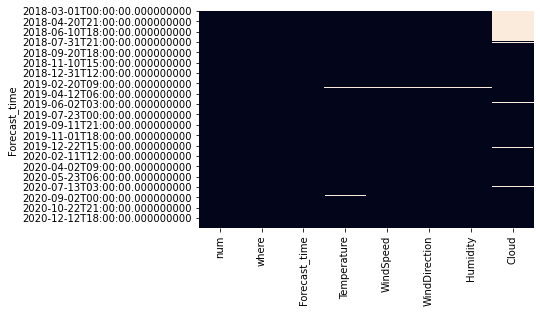

In [29]:
dangjin_obs_data1=dangjin_obs_data
dangjin_obs_data1.index=dangjin_obs_data1['Forecast_time']
dangjin_obs_data1.drop(['Forecast_time'],axis=1)
sns.heatmap(dangjin_obs_data1.isnull(),cbar=False)

In [26]:
dangjin_joined = pd.merge(energy, dangjin_obs_data, left_on='time', right_on='Forecast_time', how='inner')
cols = ['time','dangjin_floating','dangjin_warehouse','dangjin', 'Temperature', 'WindSpeed', 'WindDirection', 'Humidity', 'Cloud']
dangjin = dangjin_joined[cols]

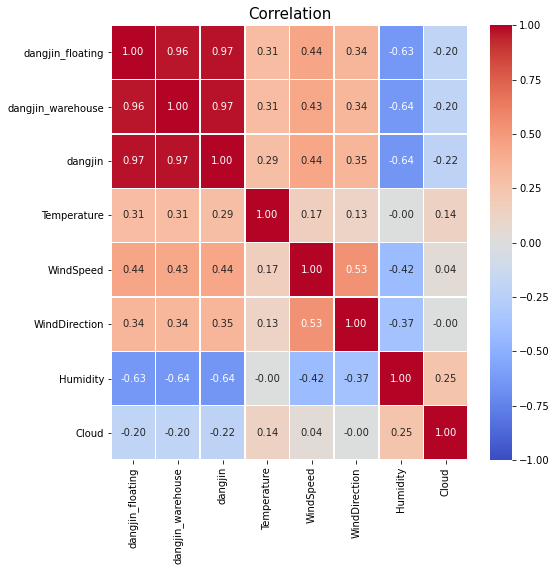

In [27]:
import seaborn as sns
plt.figure(figsize=(8,8))
plt.title("Correlation", fontsize=15)
sns.heatmap(data = dangjin.corr(),
            annot=True,
            fmt = '.2f', linewidths=.5, cmap='coolwarm',
           vmin = -1, vmax = 1, center = 0)
plt.show()

C:\Users\82104\anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



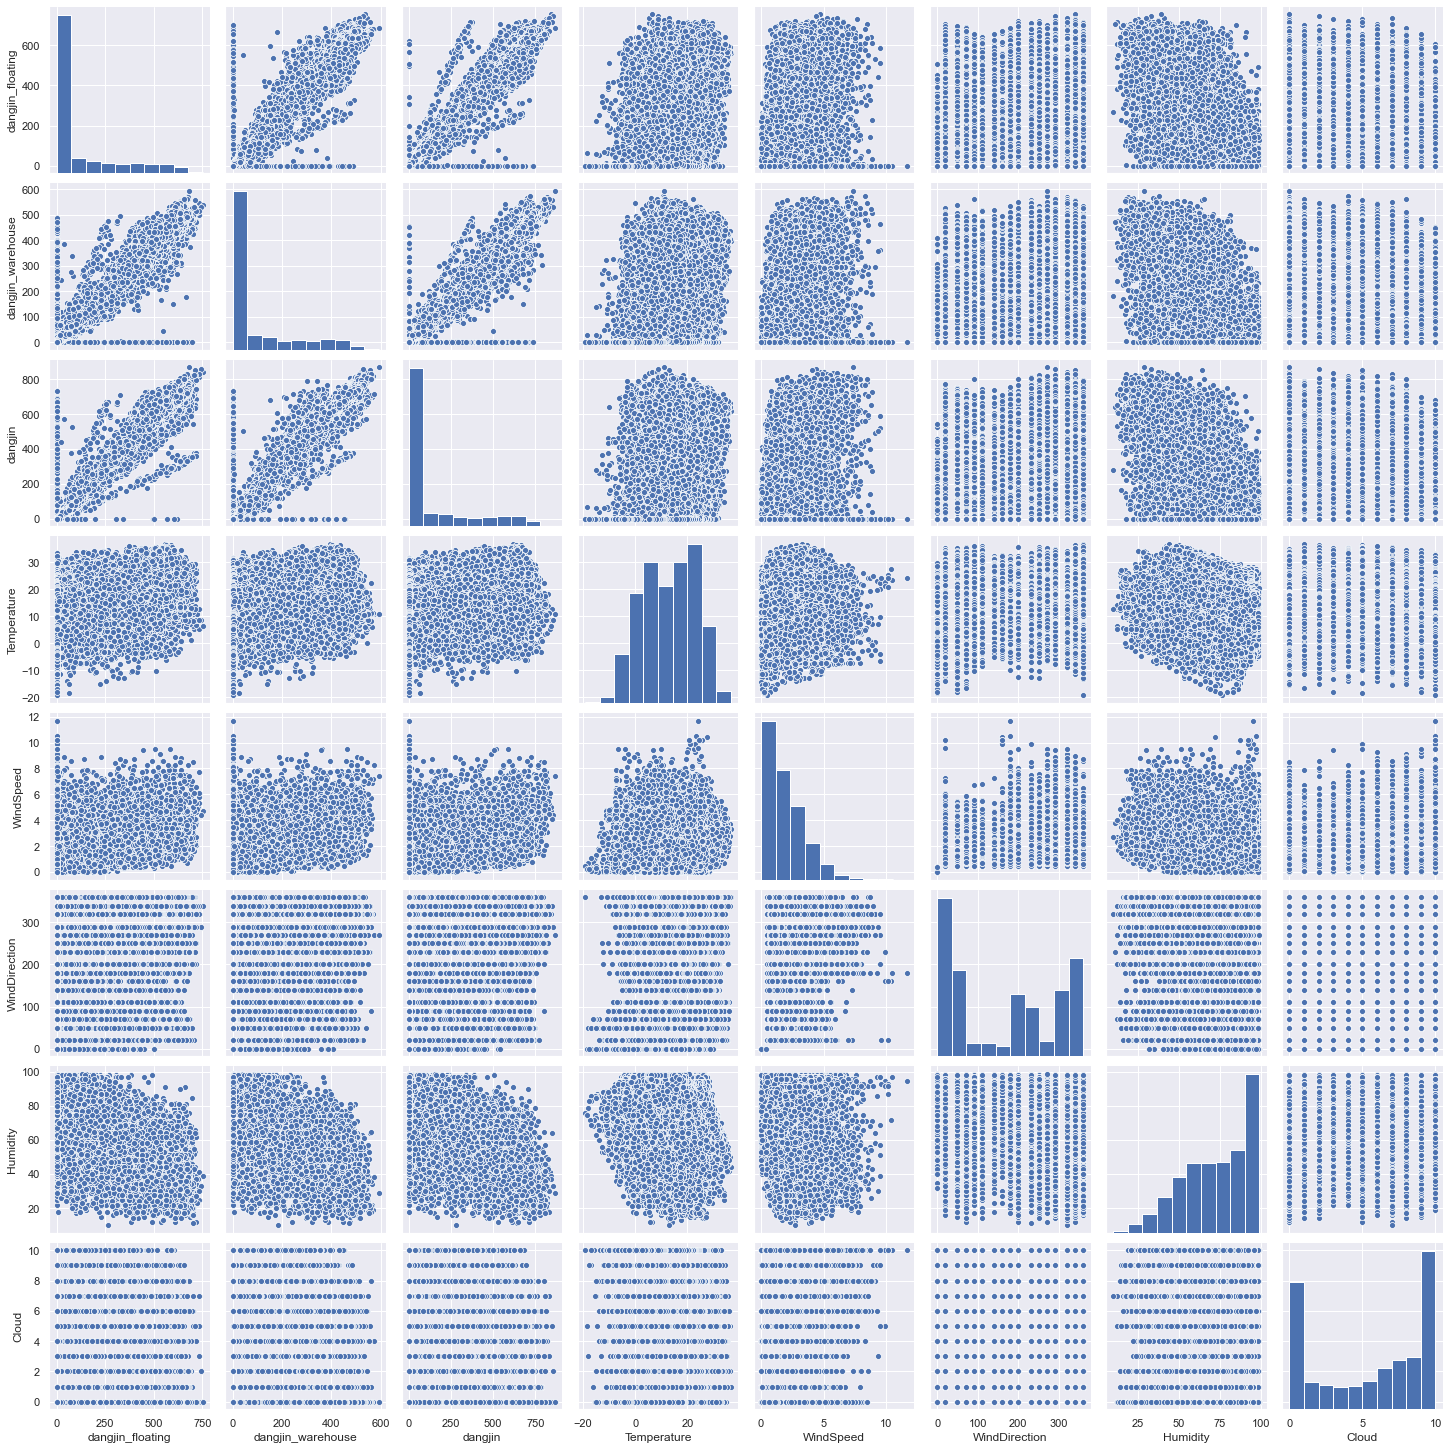

In [28]:
sns.set()
sns.pairplot(dangjin, size = 2.5)
plt.show()

### ulsan_obs_data

전운량(10분위) : 전운량(낮을 수록 구름이 적음)

In [3]:
ulsan_obs_data = pd.read_csv('ulsan_obs_data.csv')

In [175]:
len(ulsan_obs_data['전운량(10분위)'].unique())

12

In [4]:
ulsan_obs_data

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
0,152,울산,2018-03-01 00:00,8.20000,3.90000,340.00000,98.00000,10.00000
1,152,울산,2018-03-01 01:00,7.00000,4.10000,320.00000,97.00000,10.00000
2,152,울산,2018-03-01 02:00,6.50000,5.90000,290.00000,80.00000,nan
3,152,울산,2018-03-01 03:00,6.20000,4.60000,320.00000,79.00000,3.00000
4,152,울산,2018-03-01 04:00,6.70000,4.50000,320.00000,73.00000,1.00000
...,...,...,...,...,...,...,...,...
25627,152,울산,2021-01-31 19:00,8.80000,2.50000,200.00000,50.00000,5.00000
25628,152,울산,2021-01-31 20:00,8.70000,3.90000,200.00000,49.00000,1.00000
25629,152,울산,2021-01-31 21:00,8.40000,2.40000,230.00000,51.00000,7.00000
25630,152,울산,2021-01-31 22:00,9.40000,3.30000,230.00000,51.00000,8.00000


In [176]:
ulsan_obs_data['일시'] = pd.to_datetime(ulsan_obs_data['일시'])

In [177]:
ulsan_obs_data.columns=['num','where','Forecast_time','Temperature','WindSpeed','WindDirection','Humidity','Cloud']

In [80]:
print(sum(ulsan_obs_data['Forecast_time'].isna())) #0
print(sum(ulsan_obs_data['Temperature'].isna())) #4
print(sum(ulsan_obs_data['Humidity'].isna())) #1
print(sum(ulsan_obs_data['WindSpeed'].isna())) # 1
print(sum(ulsan_obs_data['WindDirection'].isna())) # 1
print(sum(ulsan_obs_data['Cloud'].isna())) # 825

0
4
1
1
1
825


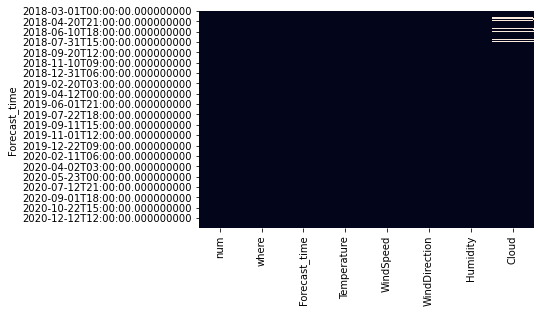

In [172]:
ulsan_obs_data1=ulsan_obs_data
ulsan_obs_data1.index=ulsan_obs_data1['Forecast_time']
ulsan_obs_data1.drop(['Forecast_time'],axis=1)
sns.heatmap(ulsan_obs_data1.isnull(),cbar=False)

In [178]:
ulsan_joined = pd.merge(energy, ulsan_obs_data, left_on='time', right_on='Forecast_time', how='inner')
cols = ['time','ulsan', 'Temperature','WindSpeed','WindDirection','Humidity','Cloud']
ulsan = ulsan_joined[cols]

In [180]:
ulsan_intp=ulsan.interpolate()

In [181]:
ulsan_intp_2020=ulsan_intp
ulsan_intp_2020['time']=ulsan_intp_2020['time'].astype(str)
ulsan_intp_2020=ulsan_intp_2020[ulsan_intp_2020['time'].str.contains('2020')]

### 2020년 데이터만 활용해서 외부변수로 활용. (corrleation 확인)

In [183]:
other= pd.read_csv('2020.csv')

In [184]:
cols = ['강수량(mm)','증기압(hPa)', '이슬점온도(°C)','현지기압(hPa)','중하층운량(10분위)','시정(10m)','지면온도(°C)']
other = other[cols]

In [185]:
other.columns=['rain','hpa','rain_c','hpa2','cloud_mid','10m','ondo']

In [182]:
ulsan_intp_2020=ulsan_intp_2020.reset_index()

In [186]:
result=pd.concat([ulsan_intp_2020, other], axis=1)

In [193]:
cols=['time', 'ulsan', 'Temperature', 'WindSpeed', 'WindDirection','Humidity', 'Cloud', 'rain', 'hpa', 'rain_c', 'hpa2', 'cloud_mid','10m', 'ondo']

In [194]:
result = result[cols]

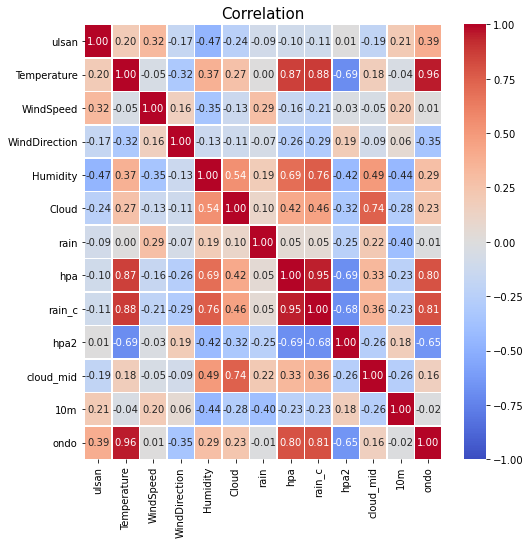

In [195]:
import seaborn as sns
plt.figure(figsize=(8,8))
plt.title("Correlation", fontsize=15)
sns.heatmap(data = result.corr(),
            annot=True,
            fmt = '.2f', linewidths=.5, cmap='coolwarm',
           vmin = -1, vmax = 1, center = 0)
plt.show()

C:\Users\82104\anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



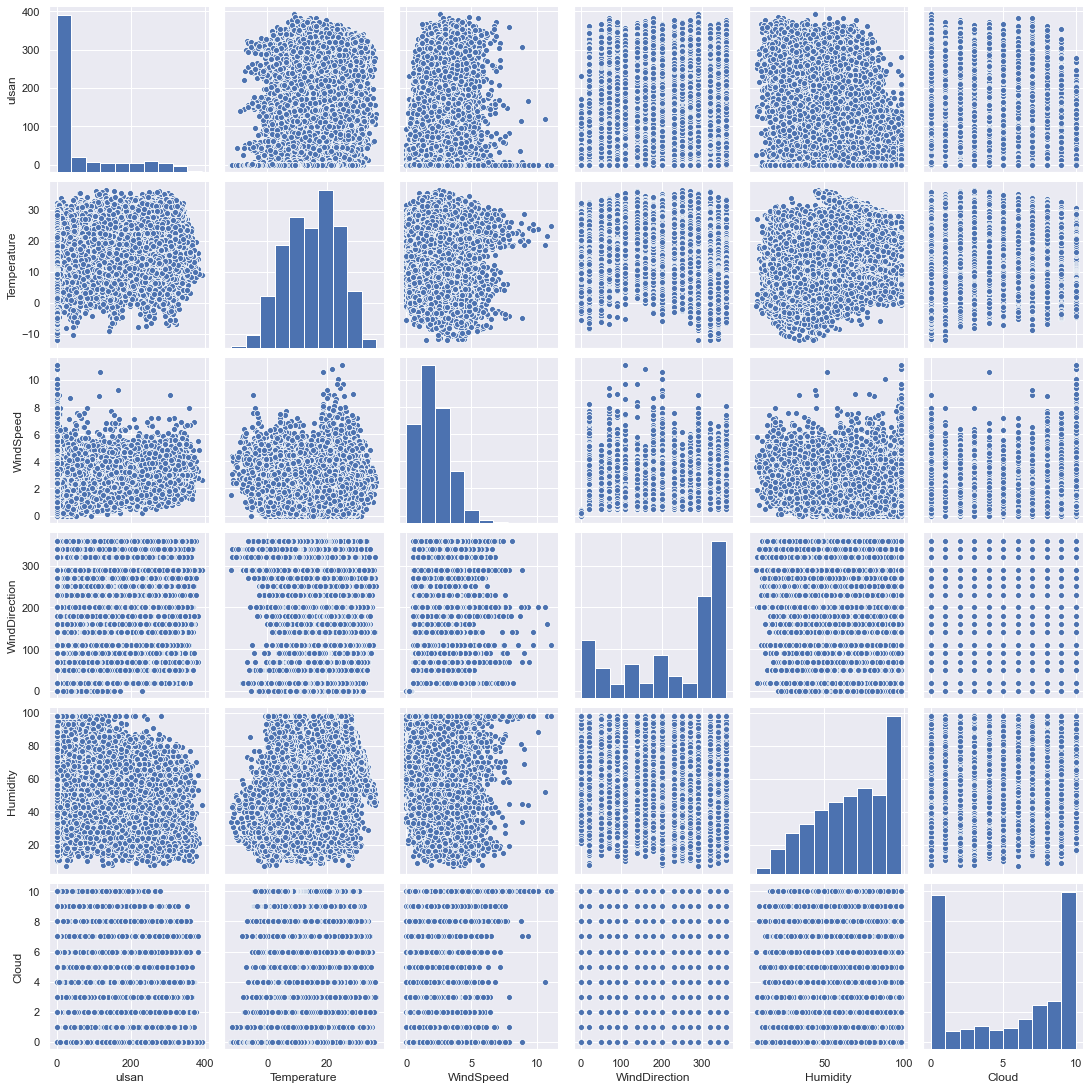

In [36]:
sns.set()
cols = ['ulsan','Temperature','WindSpeed','WindDirection','Humidity','Cloud']
sns.pairplot(ulsan[cols], size = 2.5)
plt.show();

### sample_submission

In [37]:
sample_submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0,0,0,0
1,2021-02-01 02:00:00,0,0,0,0
2,2021-02-01 03:00:00,0,0,0,0
3,2021-02-01 04:00:00,0,0,0,0
4,2021-02-01 05:00:00,0,0,0,0
5,2021-02-01 06:00:00,0,0,0,0
6,2021-02-01 07:00:00,0,0,0,0
7,2021-02-01 08:00:00,0,0,0,0
8,2021-02-01 09:00:00,0,0,0,0
9,2021-02-01 10:00:00,0,0,0,0


### NMAE-10

In [38]:
import pandas as pd
import numpy as np

def sola_nmae(answer_df, submission_df):
    submission = submission_df[submission_df['time'].isin(answer_df['time'])]
    submission.index = range(submission.shape[0])
    
    # 시간대별 총 발전량
    sum_submission = submission.iloc[:,1:].sum(axis=1)
    sum_answer = answer_df.iloc[:,1:].sum(axis=1)
    # 발전소 발전용량
    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }
    # 총 발전용량
    total_capacity = np.sum(list(capacity.values()))
    # 총 발전용량 절대오차
    absolute_error = (sum_answer - sum_submission).abs()
    # 발전용량으로 정규화
    absolute_error /= total_capacity
    # 총 발전용량의 10% 이상 발전한 데이터 인덱스 추출
    target_idx = sum_answer[sum_answer>=total_capacity*0.1].index
    # NMAE(%)
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae